In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib


You should consider upgrading via the '/home/jonatas/project/material-aula-ds-pucrio/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
# baixando o dataset

from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

# criando os splits

small_train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(10000,10500))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

/home/jonatas/project/material-aula-ds-pucrio/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset yelp_review_full (/home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)
100%|██████████| 2/2 [00:00<00:00, 125.77it/s]
Loading cached shuffled indices for dataset at /home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a0e621c27d9b360e.arrow
Loading cached shuffled indices for dataset at /home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a0e621c27d9b360e.arrow
Loading cached shuffled indices for 

In [3]:
small_train_dataset[0]

{'label': 4,
 'text': "I stalk this truck.  I've been to industrial parks where I pretend to be a tech worker standing in line, strip mall parking lots, and of course the farmer's market.  The bowls are so so absolutely divine.  The owner is super friendly and he makes each bowl by hand with an incredible amount of pride.  You gotta eat here guys!!!"}

In [4]:
set(small_train_dataset["label"])

{0, 1, 2, 3, 4}

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

# carregando o modelo
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

# carregando o tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [6]:
# tokenizando os dados

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-86049dadb1c6237c.arrow
Loading cached processed dataset at /home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-37e6a6f6a019c35f.arrow
Loading cached processed dataset at /home/jonatas/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-0e08fc264cf26f4c.arrow


In [7]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "test_trainer_v0"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    max_steps=1000,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=10,
    eval_steps=50,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

In [8]:
trainer.train()

/home/jonatas/project/material-aula-ds-pucrio/venv/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 1.6104, 'learning_rate': 2.97e-05, 'epoch': 0.03}
{'loss': 1.5134, 'learning_rate': 2.94e-05, 'epoch': 0.06}
{'loss': 1.3924, 'learning_rate': 2.91e-05, 'epoch': 0.1}
{'loss': 1.2792, 'learning_rate': 2.88e-05, 'epoch': 0.13}
{'loss': 1.2105, 'learning_rate': 2.8499999999999998e-05, 'epoch': 0.16}
{'eval_loss': 1.2539870738983154, 'eval_accuracy': 0.472, 'eval_runtime': 6.4401, 'eval_samples_per_second': 77.639, 'eval_steps_per_second': 2.484, 'epoch': 0.16}
{'loss': 1.2091, 'learning_rate': 2.8199999999999998e-05, 'epoch': 0.19}
{'loss': 1.1332, 'learning_rate': 2.79e-05, 'epoch': 0.22}
{'loss': 1.0723, 'learning_rate': 2.7600000000000003e-05, 'epoch': 0.26}
{'loss': 1.0385, 'learning_rate': 2.7300000000000003e-05, 'epoch': 0.29}
{'loss': 1.0789, 'learning_rate': 2.7000000000000002e-05, 'epoch': 0.32}
{'eval_loss': 1.1550742387771606, 'eval_accuracy': 0.514, 'eval_runtime': 6.5329, 'eval_samples_per_second': 76.536, 'eval_steps_per_second': 2.449, 'epoch': 0.32}
{'loss': 1.06

TrainOutput(global_step=1000, training_loss=0.7811525411605835, metrics={'train_runtime': 1345.0702, 'train_samples_per_second': 23.791, 'train_steps_per_second': 0.743, 'train_loss': 0.7811525411605835, 'epoch': 3.19})

In [10]:
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.6104,2.970000e-05,0.03,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5134,2.940000e-05,0.06,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.3924,2.910000e-05,0.10,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2792,2.880000e-05,0.13,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.2105,2.850000e-05,0.16,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.4780,6.000000e-07,3.13,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.4347,3.000000e-07,3.16,990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,0.4597,0.000000e+00,3.19,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,3.19,1000,1.205626,0.564,6.8801,72.673,2.326,NaN,NaN,NaN,NaN,NaN


<Axes: >

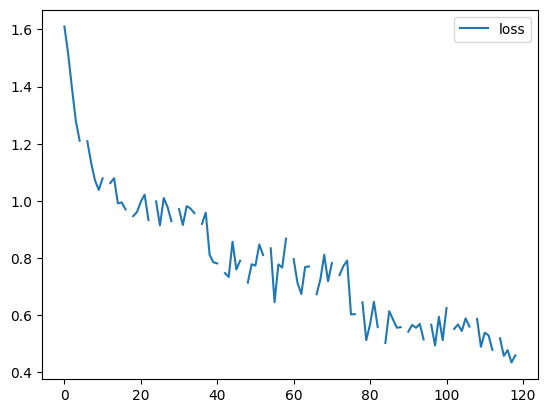

In [14]:
df_log.plot(y=["loss"])


<Axes: >

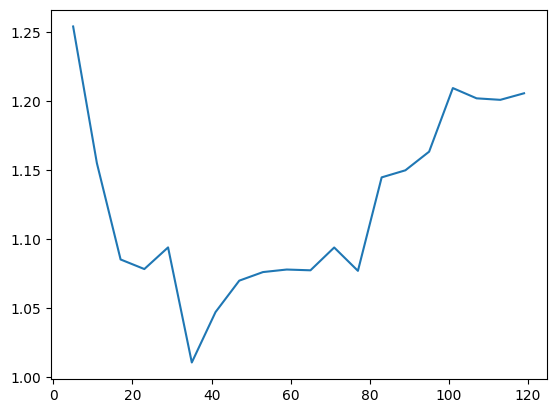

In [18]:
df_log["eval_loss"].dropna().plot()

<Axes: >

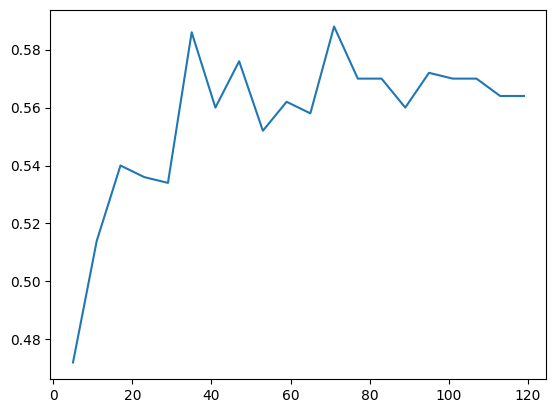

In [17]:
df_log["eval_accuracy"].dropna().plot()


In [19]:
# avaliando o modelo

trainer.evaluate(tokenized_small_test_dataset)


{'eval_loss': 0.9540801048278809, 'eval_accuracy': 0.596, 'eval_runtime': 5.5427, 'eval_samples_per_second': 90.209, 'eval_steps_per_second': 2.887, 'epoch': 3.19}


{'eval_loss': 0.9540801048278809,
 'eval_accuracy': 0.596,
 'eval_runtime': 5.5427,
 'eval_samples_per_second': 90.209,
 'eval_steps_per_second': 2.887,
 'epoch': 3.19}

In [20]:
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('test_trainer_v0/tokenizer_config.json',
 'test_trainer_v0/special_tokens_map.json',
 'test_trainer_v0/vocab.txt',
 'test_trainer_v0/added_tokens.json',
 'test_trainer_v0/tokenizer.json')

In [24]:
# carregando o modelo e rodando um predict

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

text = "This is a really good restaurant"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output.logits

# convertendo a saída para probabilidades

import torch.nn.functional as F

probabilities = F.softmax(output.logits, dim=-1)
probabilities

# convertendo a saída para labels

predicted_class_idx = torch.argmax(probabilities, dim=-1)
predicted_class_idx

probabilities



tensor([[0.0024, 0.0028, 0.0195, 0.3237, 0.6516]], grad_fn=<SoftmaxBackward0>)

In [ ]:
encoded_input